In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import re
from scipy.optimize import curve_fit


In [2]:
def load_file(filenm):
    """
    Load xvg - file and return a pandas dataframe. 
    """
    data = []
    with open(filenm) as f:
        for line in f:
            #If line starts with @ or #, skip
            if line.startswith(('#', '@')):
                continue
            data.append([float(x) for x in re.split(r'\s+', line.strip())])
    return pd.DataFrame(data, columns=['time', 'value'])

In [3]:
def plot_variable_vs_reference(df, ref, used_var, name=None):
    """
    Plots reference distribution as normalised histogram, and variable as kde-plot.
    Also shows the value of the variable used in the simulation by a red line.
    """
    sns.histplot(ref.value, stat='density', label='Reference', bins=50, kde=True)
    sns.kdeplot(df.value,label='Variable', color='red', alpha=0.5)
    ymin, ymax = plt.ylim()
    plt.plot([used_var, used_var], [ymin, ymax], color='red', label='Used value', ls='--', lw=2)
    plt.legend()
    plt.title(name)
    plt.show()

In [4]:
def get_var_value(version):
    ITP_PATH = f"{version}/CG_motor*.itp"

    bonds = []
    angles = []
    dihedrals = []
    bcheck, acheck, dcheck = False, False, False

    with open(glob.glob(ITP_PATH)[0]) as f:
        for line in f:
            if line.startswith(';'):
                continue
            if line.startswith('[ bonds ]') or line.startswith('[ constraints ]'):
                bcheck = True
                continue
            if line.startswith('[ angles ]'):
                bcheck = False
                acheck = True
                continue
            if line.startswith('[ dihedrals ]'):
                acheck = False
                dcheck = True
                continue
            if line.startswith('['):
                bcheck, acheck, dcheck = False, False, False
                continue
            if len(re.split(r'\s+', line.strip())) < 2:
                continue
            if bcheck:
                bonds.append(float(re.split(r'\s+', line.strip())[3]))
            if acheck:
                angles.append(float(re.split(r'\s+', line.strip())[4]))
            if dcheck:
                dihedrals.append(float(re.split(r'\s+', line.strip())[5]))
    return bonds, angles, dihedrals

In [5]:
def fit_quartic_angle(df):
    """
    Fits the function:
        f(theta) = C2 (theta-theta0)^2 + C4 (theta - theta0)^4
    to the angle distribution of the value column of df.

    Returns theta0, C2, C4
    """
    def func(theta, theta0, C2, C4):
        return C2 * (theta - theta0)**2 + C4 * (theta - theta0)**4

    hist = np.histogram(df.value, bins=100, density=True)
    x, y = hist[1], hist[0]
    x = np.convolve(x, np.ones(2)/2, mode='valid')
    popt, pcov = curve_fit(func, x, y, p0=[0, 1, 1])
    return popt

In [10]:
version = "v5"
bonds, angles, dihedrals = get_var_value(version)
var_map = {'bonds': bonds, 'angles': angles, 'dihedrals': dihedrals}


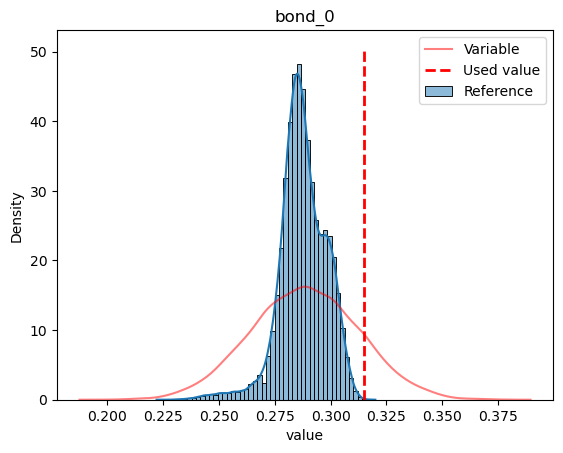

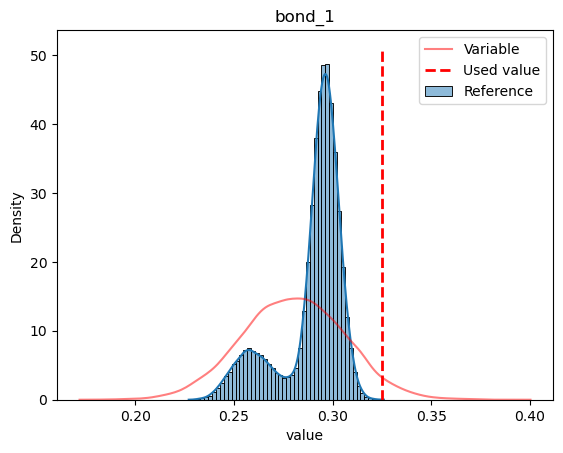

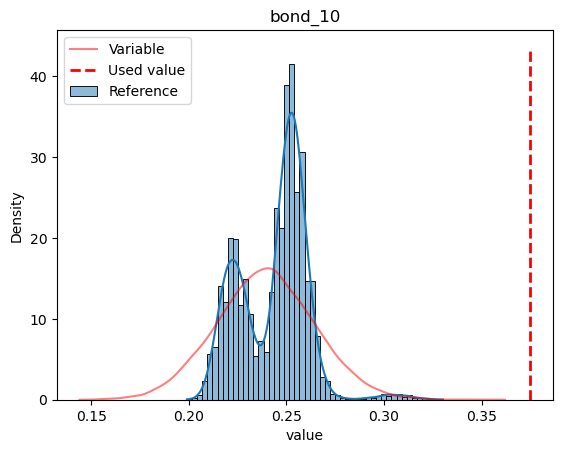

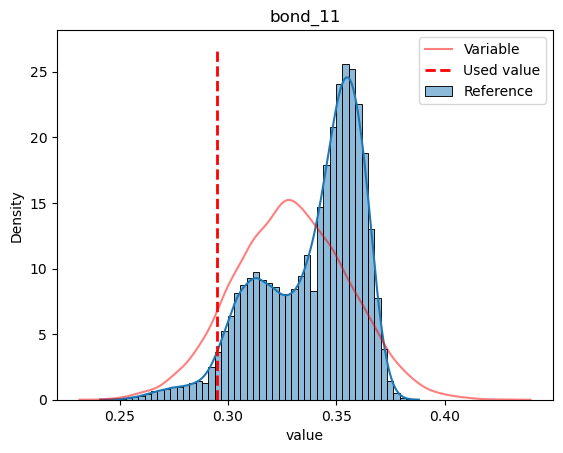

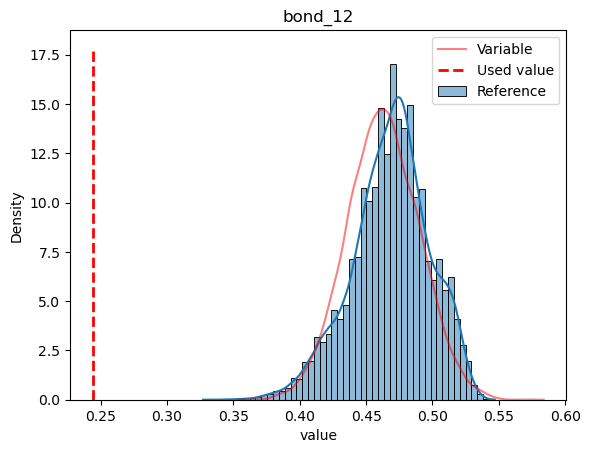

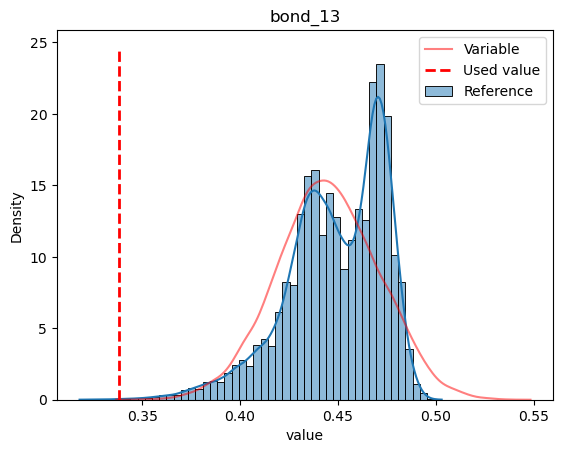

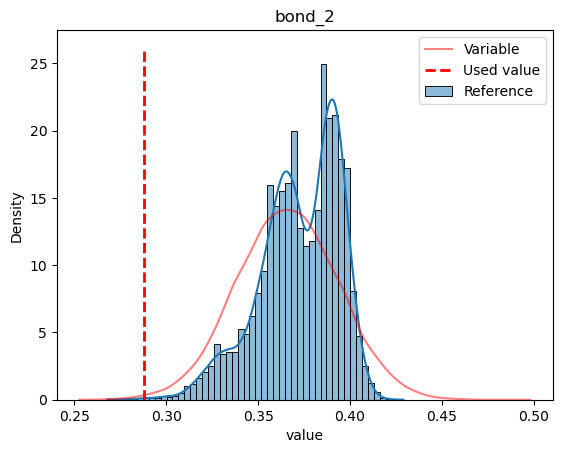

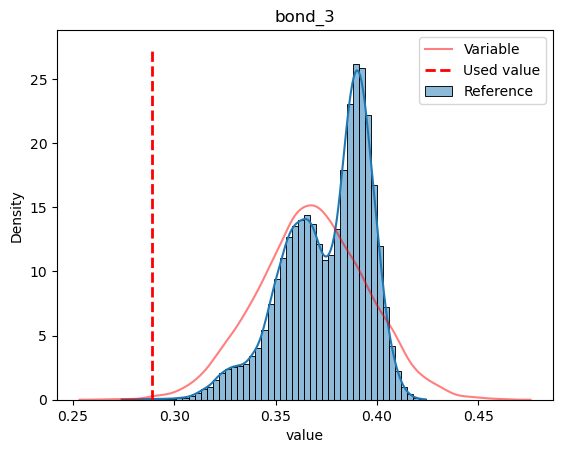

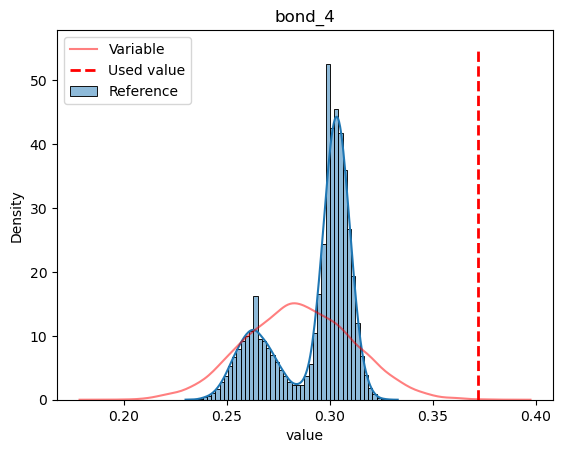

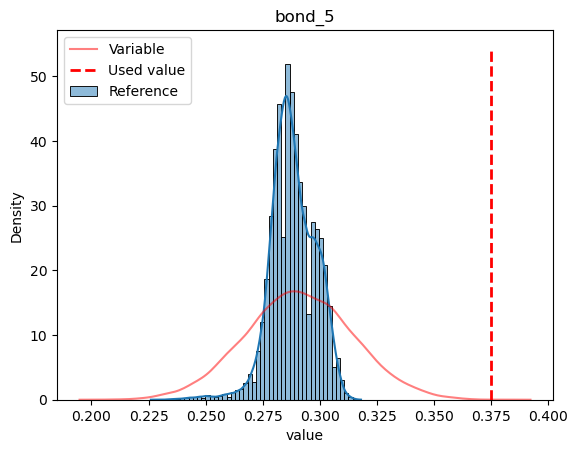

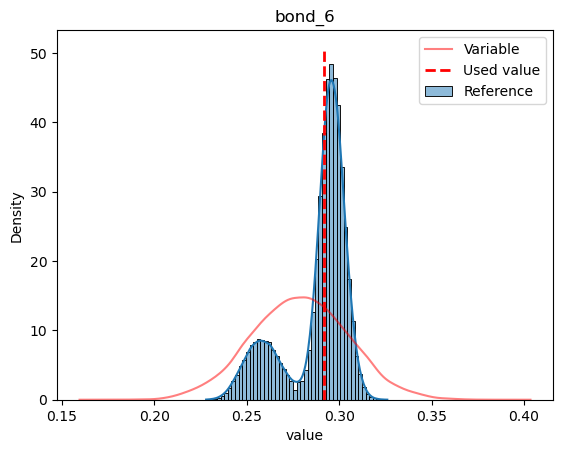

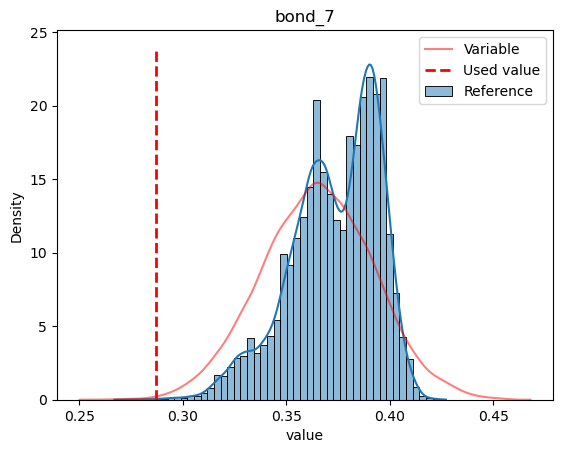

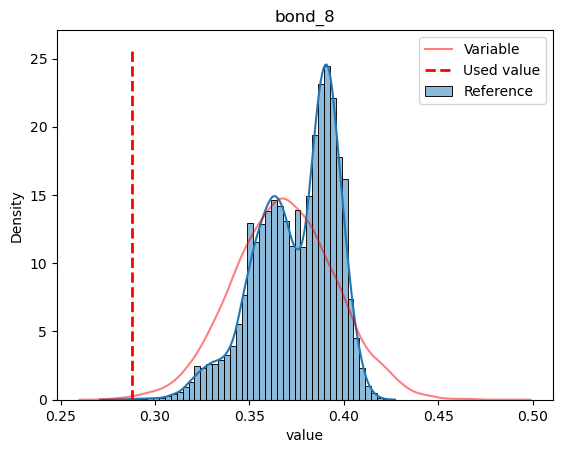

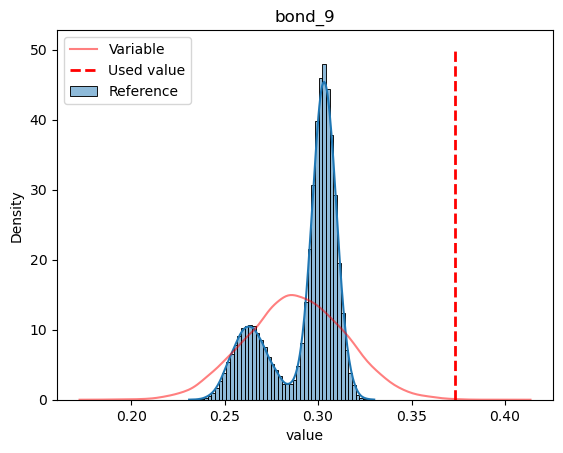

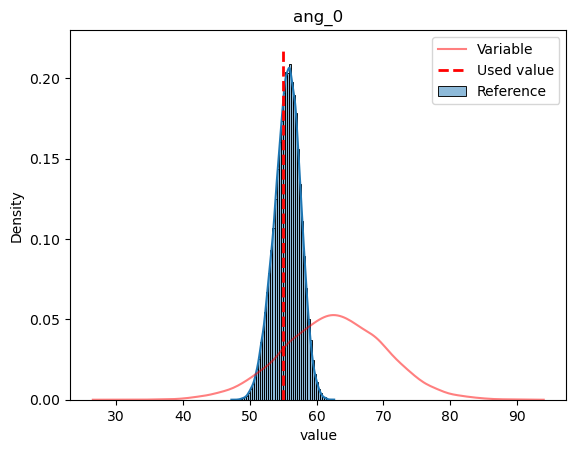

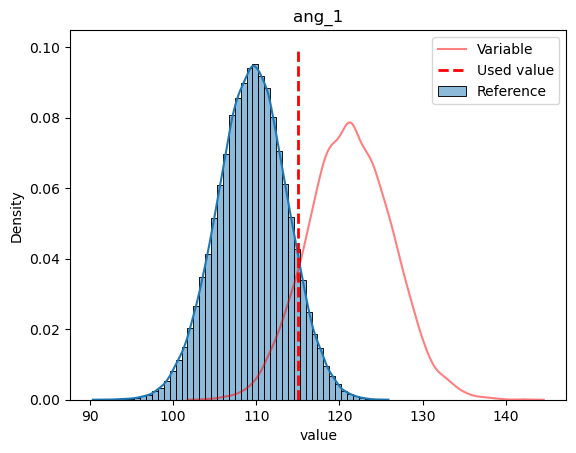

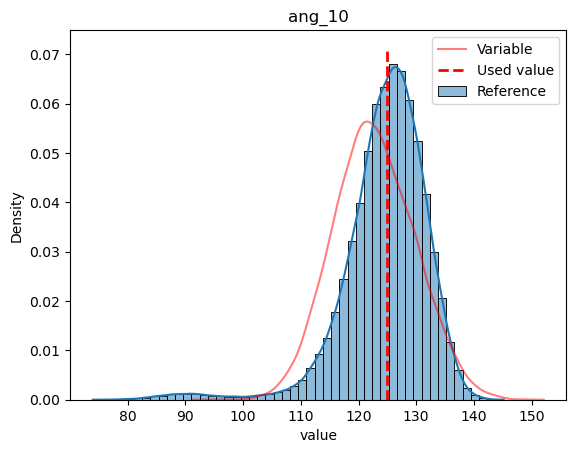

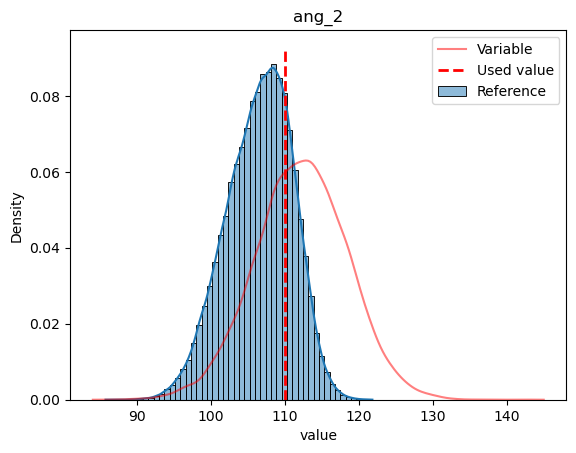

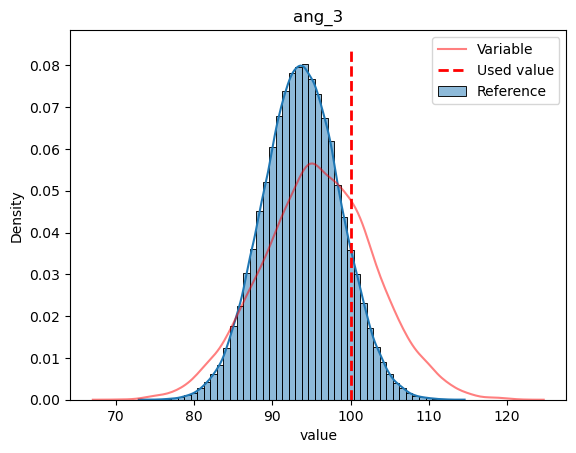

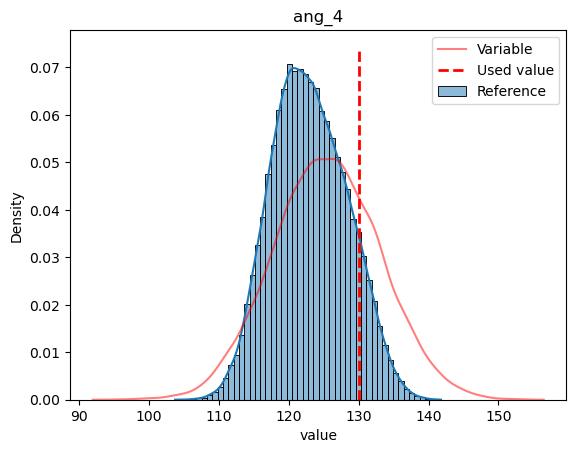

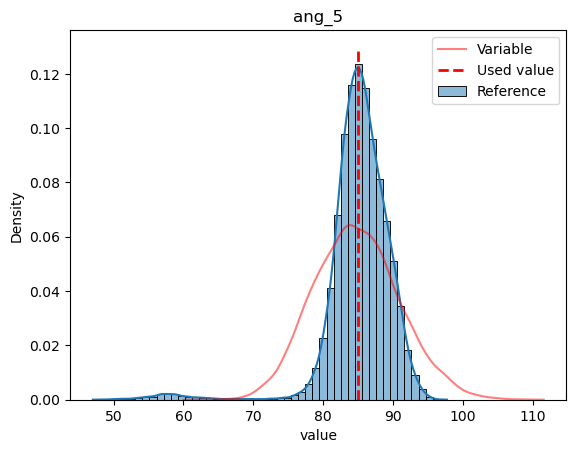

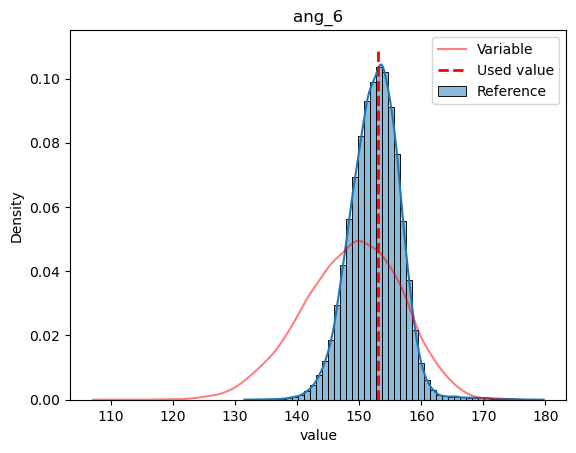

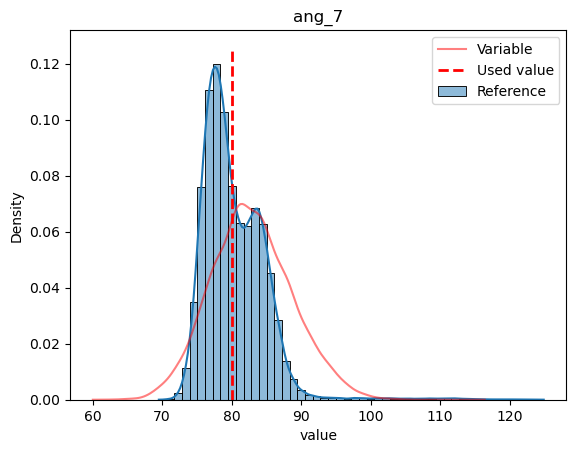

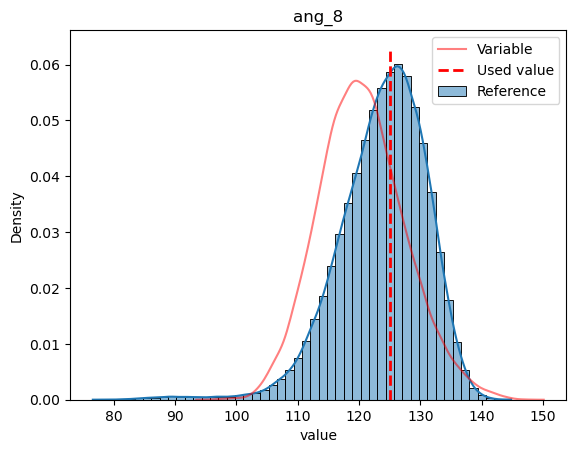

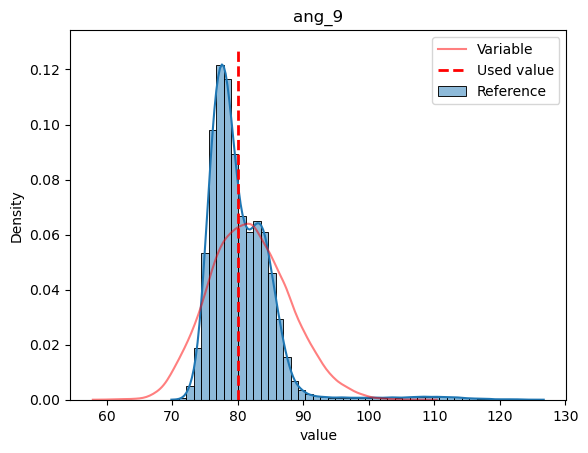

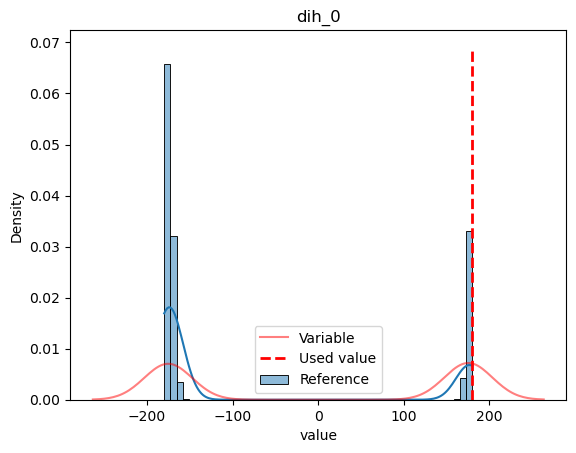

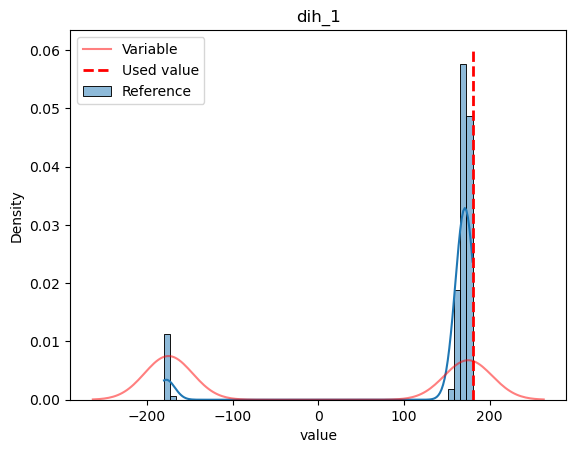

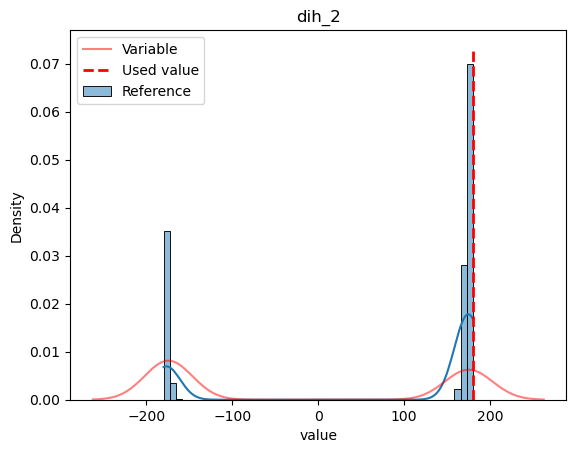

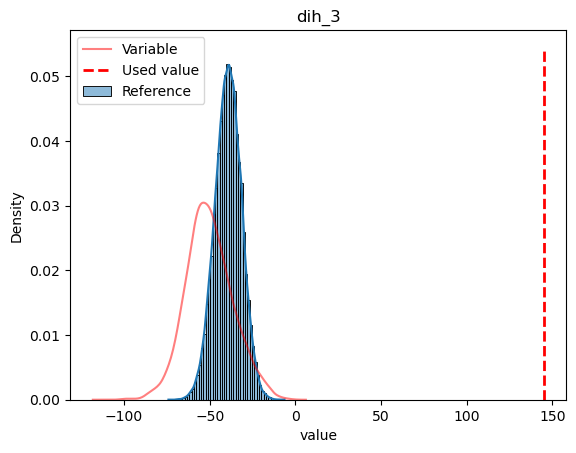

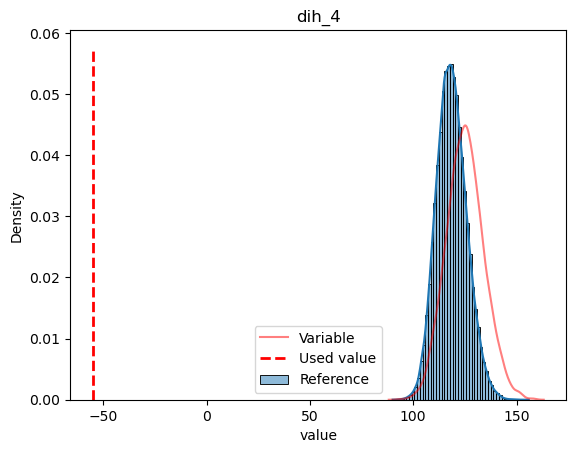

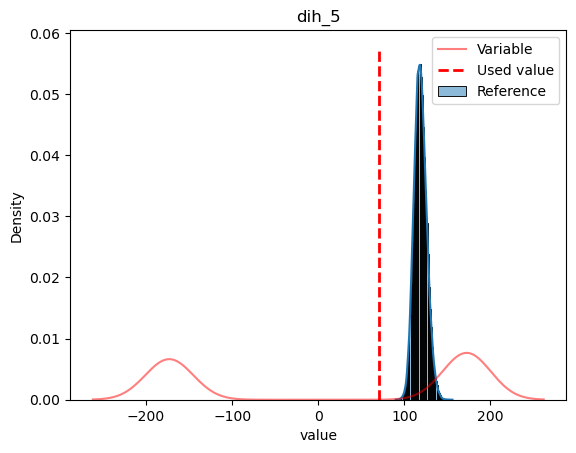

In [11]:
for var in ['bonds', 'angles', 'dihedrals']:
    for type in sorted(glob.glob(f"{version}/{var}_mapped/*.xvg")):
        df = load_file(type)
        varnr = type.split('/')[-1][:-4]
        ref = load_file(f"reference/{var}_mapped/{varnr}.xvg")
        
        used_var = var_map[var][int(varnr.split('_')[-1])]
        plot_variable_vs_reference(df, ref, used_var, name=varnr)

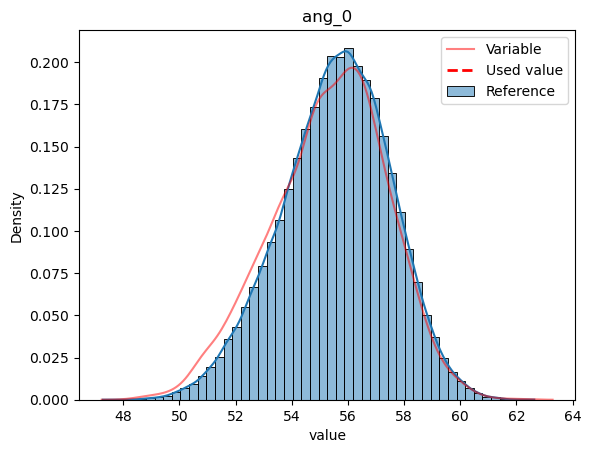

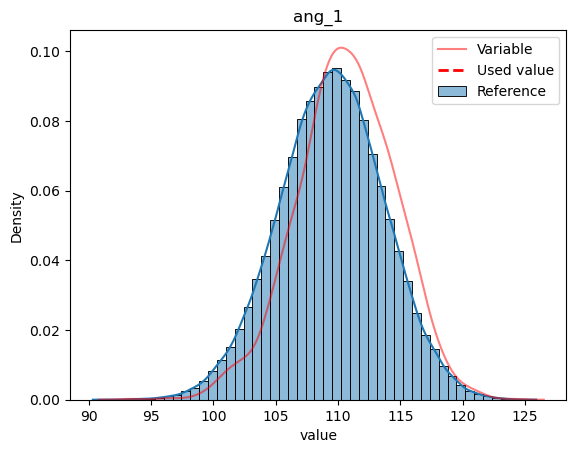

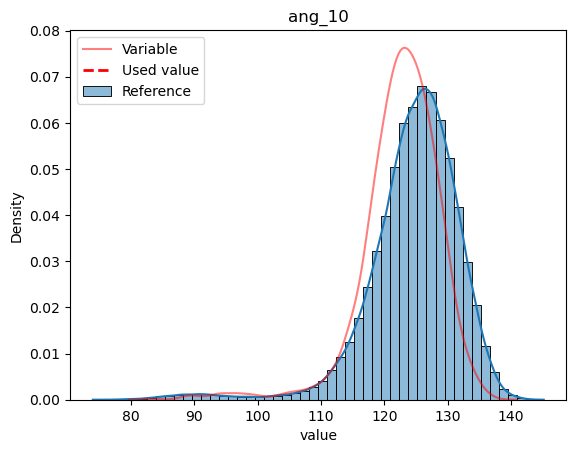

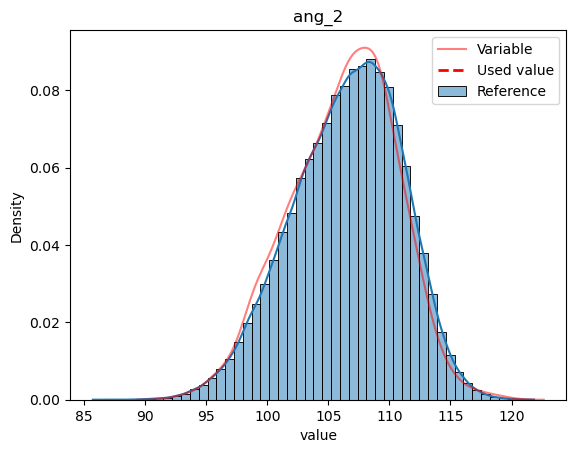

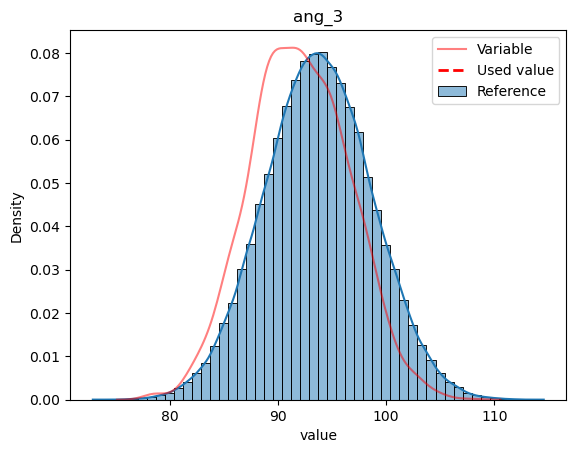

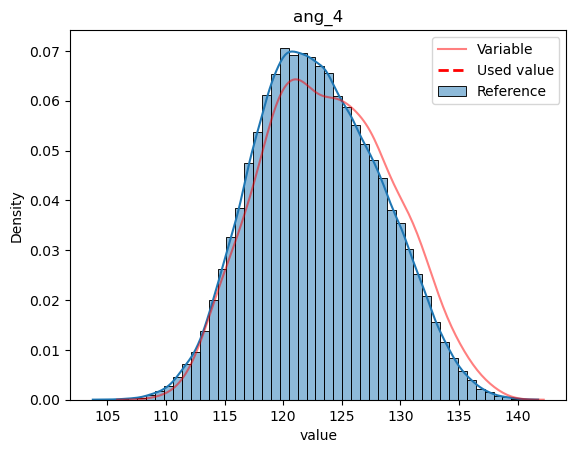

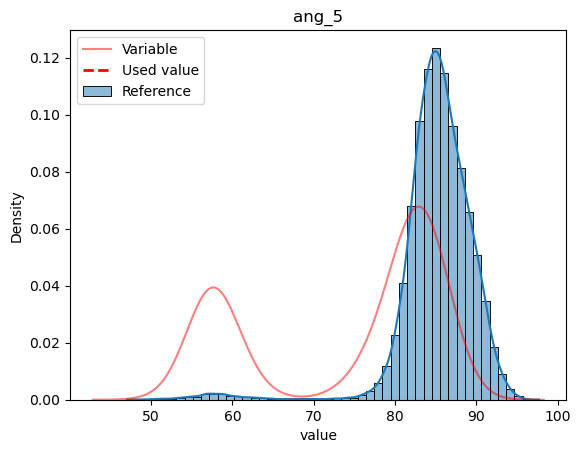

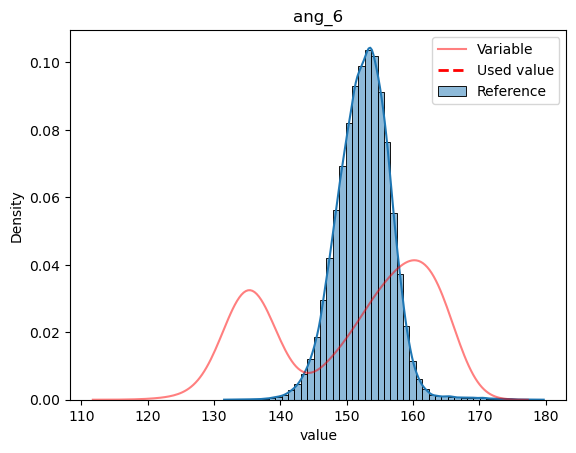

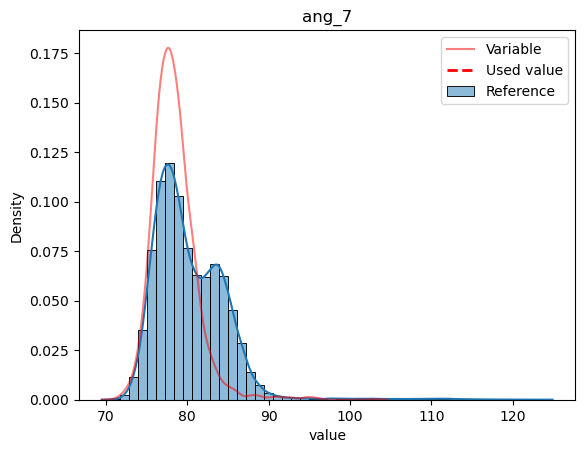

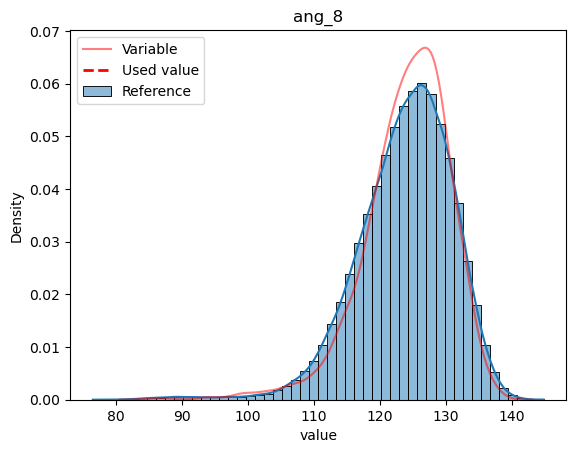

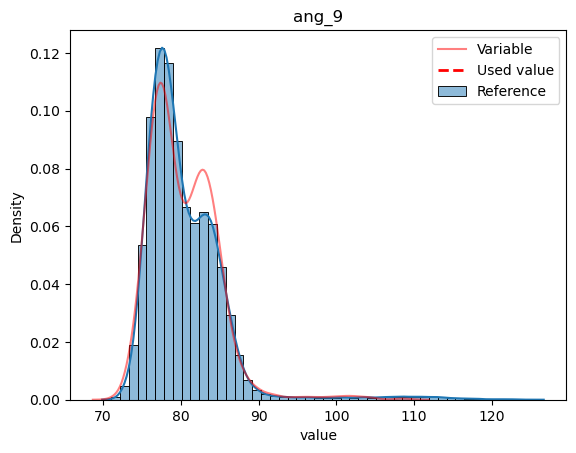

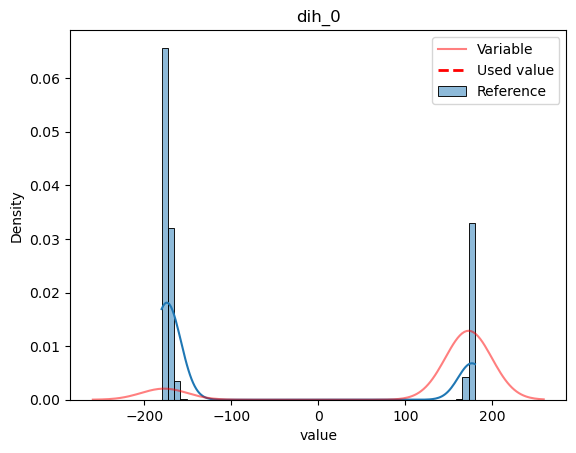

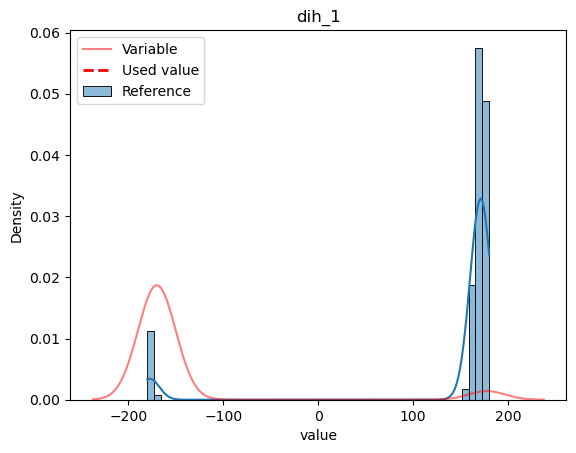

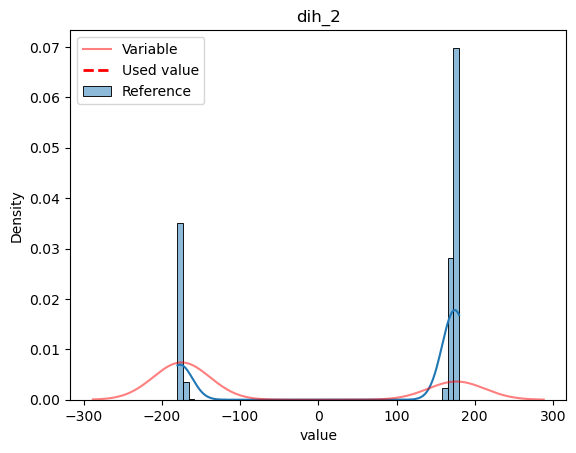

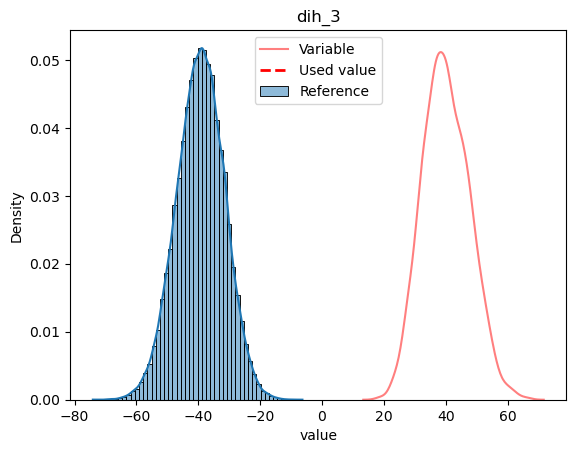

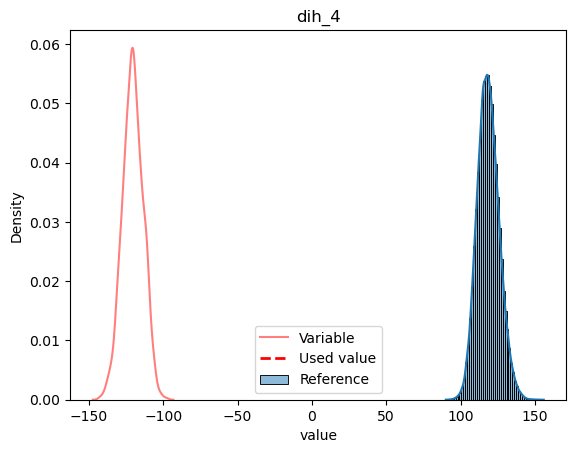

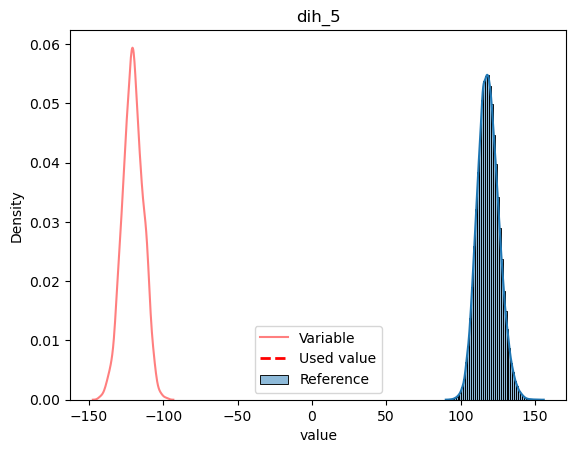

In [12]:
for var in ['angles', 'dihedrals']:
    for type in sorted(glob.glob(f"reference/{var}_mapped/*.xvg")):
        R = load_file(type)
        varnr = type.split('/')[-1][:-4]
        S = load_file(f"reference-S/{var}_mapped/{varnr}.xvg")
        df = load_file(f"{version}/{var}_mapped/{varnr}.xvg")
        plot_variable_vs_reference(S,R, np.nan, name=varnr)